## 18.4 Shortest paths

This section introduces an algorithm to solve the
**single-source shortest paths** (SSSP) problem for weighted graphs:
for each node R that is reachable from the given start node S,
find a lowest cost (total weight) path from S to R.
A typical application of the SSSP problem is to find the cheapest or fastest
way to go from one place to every other place in a transport network.

We defined the MST problem for connected undirected graphs to guarantee
that a spanning tree can be obtained, no matter the start node.
The SSSP problem is defined for any directed or undirected graph, because
it doesn't ask to connect all nodes. However, the algorithm to be shown
only works for graphs with non-negative weights;
most models of real-world networks don't have negative weights,
so this isn't much of a restriction in practice.

### 18.4.1 Algorithm

The algorithm is again a graph traversal that produces a tree
rooted at the start node, with a single path to each reachable node.
In fact, it's a small modification of Prim's algorithm.

Prim's algorithm greedily chooses in each iteration the unvisited node
'nearest' to *any* visited node, because
it's minimising the total weight of the tree.
The SSSP algorithm chooses instead the unvisited node
'nearest' to *one* visited node, namely the start node, because
it's minimising the weight of the paths beginning at the start node.
This is known as **Dijkstra's algorithm**, named after its inventor.

You should now watch a [visualisation](https://learn2.open.ac.uk/mod/oucontent/view.php?id=2383768&extra=thumbnail_idm46) that explains the gist
of Dijkstra's algorithm, applied to a connected undirected graph in which
weights represent distances. The visualisation doesn't create a tree with
the shortest paths: it only computes their weights.
Extra work is then needed to obtain the paths.

Now that you've seen the algorithm in action, let's see why it works.
The next figure shows schematically the shortest paths to nodes A and B,
with total weights *ta* and *tb*, respectively.
In addition there's an edge with non-negative weight *w* from B to A.

<p id="fig-18.4.1"></p>

*[Figure 18.4.1](../33_Figures/Figures_18_4.ipynb#Figure-18.4.1)*

![Image 18_4_dijkstra.png](18_4_dijkstra.png)

Let's assume that A is visited before B by the algorithm.
This means that A is 'nearer' to the start node than B,
i.e. *ta* ≤ *tb* and therefore *ta* ≤ *tb* + *w*.
In other words, the path to A via B can't be shorter.
Therefore, as soon as the algorithm picks A to visit next,
it knows it has found a shortest path.
Paths via nodes visited later won't be shorter.

Note that if *w* < 0 then we may have *ta* > *tb* + *w*.
If weights can be negative, the greedy choice of picking the next nearest node
won't always work: a shorter path may go first to a node further off and then
take a negative weight edge to obtain a lower total weight.

As I mentioned above, the visualisation doesn't construct a tree.
So let's take our version of Prim's algorithm and use different priorities.
My version of Prim's algorithm adds edge (A, B, *w*) with priority *w*
to the min-priority queue of unprocessed edges.
For Dijkstra's, the priority is the cost (total weight) of reaching B via A,
i.e. it's the cost to reach A plus *w*.

How do I know the cost of reaching A?
Well, the graph traversal only adds edge (A, B, *w*) when visiting A,
and it visits A because it took from the queue some incoming edge (C, A)
with priority *p* which is the cost of reaching A.

1. let *visited* be a weighted digraph with node *start*
2. let *unprocessed* be an empty min-priority queue
3. for each *node* in the out-neighbours of *start* in *graph*:
   1. add edge (*start*, *node*, *weight*) with priority *weight* to *unprocessed*
4. while *unprocessed* isn't empty:
   1. let (*previous*, *current*, *weight*) be max(*unprocessed*) with priority *cost*
   2. remove max(*unprocessed*)
   3. if *visited* hasn't got node *current*:
      1. add *current* to *visited*
      2. add (*previous*, *current*, *weight*) to *visited*
      3. for each *node* in the out-neighbours of *current* in *graph*:
         1. let *weight* be weight(*current*, *node*)
         1. add edge (*current*, *node*, *weight*) with priority *cost* + *weight* to *unprocessed*

The only changes to Prim's algorithm are to use out-neighbours instead of
neighbours in steps 3 and 4.3.3, to accommodate digraphs, and
computing a different priority in step&nbsp;4.3.3.2.

The changes don't affect the worst-case complexity, which is
O(*e* log *e*), like for Prim's algorithm.

<div class="alert alert-info">
<strong>Info:</strong> The worst-case complexity of both algorithms is often stated as O(<em>e</em> log <em>n</em>).
Any graph has fewer than <em>n</em>² edges and log $x^y$ = $y$ log $x$,
so O(<em>e</em> log <em>e</em>) = O(<em>e</em> log <em>n</em>²) = O(<em>e</em> × 2 × log <em>n</em>) = O(<em>e</em> log <em>n</em>).
</div>

My versions of BFS, DFS, Prim's and Dijkstra's algorithms aim to
highlight their similarities: they use the same core graph-traversal algorithm,
only differing in the order in which unprocessed edges are stored.

#### Exercise 18.4.1

If the weights in the input graph are all equal,
can you compute the shortest paths without using Dijkstra's algorithm?

_Write your answer here._

[Hint](../31_Hints/Hints_18_4_01.ipynb)
[Answer](../32_Answers/Answers_18_4_01.ipynb)

### 18.4.2 Code

Let's implement and run the algorithm.

In [1]:
%run -i ../m269_digraph
%run -i ../m269_ungraph
%run -i ../m269_graphs

Like for Prim's algorithm, I use Python's min-heaps.

In [2]:
# this code is also in m269_digraph.py

from heapq import heappush, heappop

def dijkstra(graph: WeightedDiGraph, start: Hashable) -> WeightedDiGraph:
    """Return a shortest path from start to each reachable node.

    Preconditions:
    - graph.has_node(start)
    - node objects are comparable
    - no weight is negative
    """
    visited = WeightedDiGraph()
    visited.add_node(start)

    # create min-priority queue of tuples (cost, (A, B, weight))
    # cost is total weight from start to B via shortest path to A
    unprocessed = []    # min-priority queue
    for neighbour in graph.out_neighbours(start):
        weight = graph.weight(start, neighbour)
        heappush(unprocessed, (weight, (start, neighbour, weight)) )

    while len(unprocessed) > 0:
        info = heappop(unprocessed)
        cost = info[0]
        edge = info[1]
        previous = edge[0]
        current = edge[1]
        weight = edge[2]

        if not visited.has_node(current):
            visited.add_node(current)
            visited.add_edge(previous, current, weight)
            for neighbour in graph.out_neighbours(current):
                weight = graph.weight(current, neighbour)
                edge = (current, neighbour, weight)
                heappush(unprocessed, (cost + weight, edge) )
    return visited

Let's use the example MST graph of [Section&nbsp;18.3](../18_Greed/18_3_mst.ipynb#18.3-Minimum-spanning-tree).

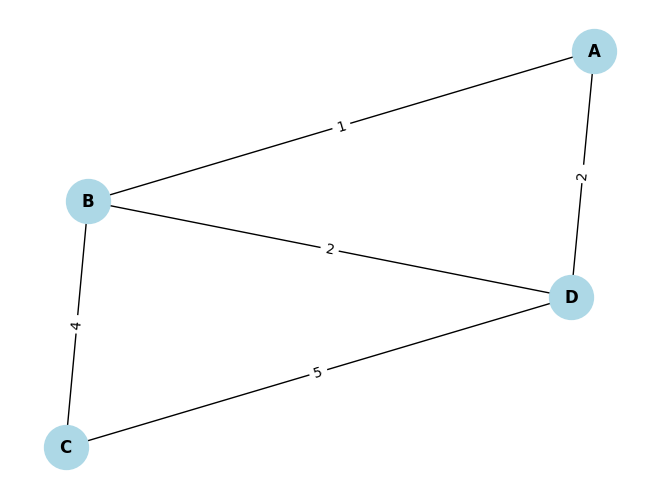

In [3]:
RHOMBUS.draw()

If the start node is A then the shortest paths happen to coincide with the MST,
if we ignore the edge directions of the output digraph.

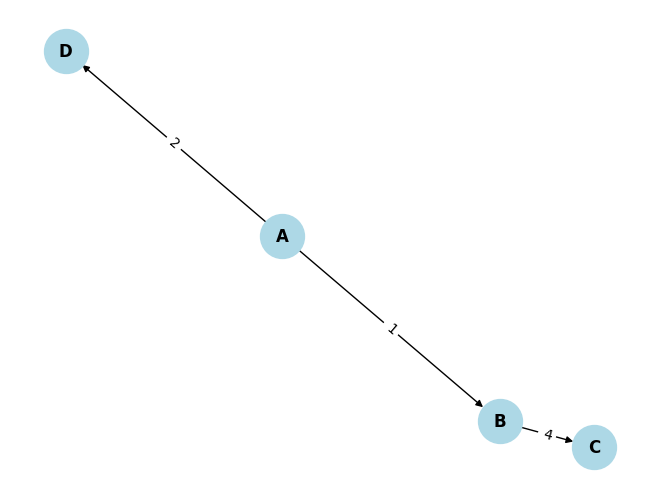

In [4]:
dijkstra(RHOMBUS, 'A').draw()

However, if the start node is D then we get a different spanning tree.

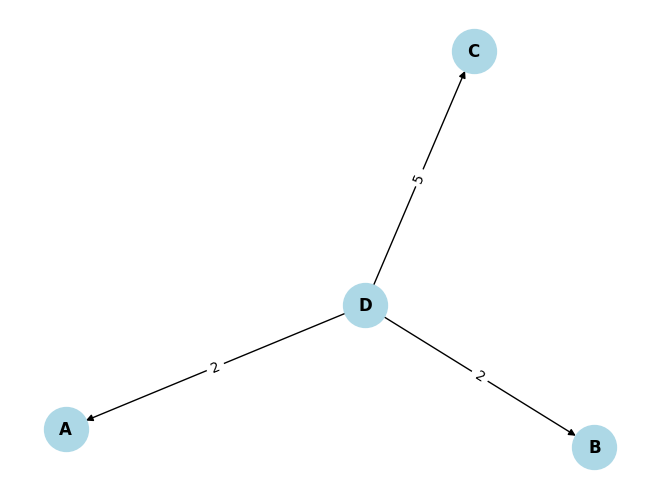

In [5]:
dijkstra(RHOMBUS, 'D').draw()

Finding the MST involves minimising the total weight of *all edges*.
Finding shortest paths involves minimising the weight of *each path*:
hence the output tree is often not an MST.

The interactive visualisation graph is another example of that.

In [6]:
# this code is also in m269_graphs.py

# graph used by the interactive visualisation of Dijkstra's algorithm
DIJKSTRA = WeightedUndirectedGraph()
for node in 'ABCDEFGHK':
    DIJKSTRA.add_node(node)
DIJKSTRA.add_edge('C', 'A', 20)
DIJKSTRA.add_edge('A', 'B', 4)
DIJKSTRA.add_edge('B', 'F', 1)
DIJKSTRA.add_edge('F', 'H', 1)
DIJKSTRA.add_edge('B', 'G', 3)
DIJKSTRA.add_edge('G', 'K', 5)
DIJKSTRA.add_edge('K', 'H', 3)
DIJKSTRA.add_edge('C', 'D', 2)
DIJKSTRA.add_edge('D', 'E', 2)
DIJKSTRA.add_edge('E', 'G', 3)
DIJKSTRA.add_edge('E', 'K', 3)

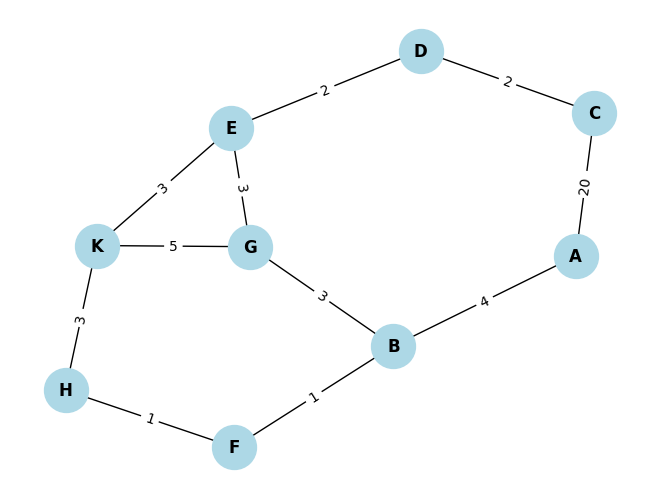

In [7]:
DIJKSTRA.draw()

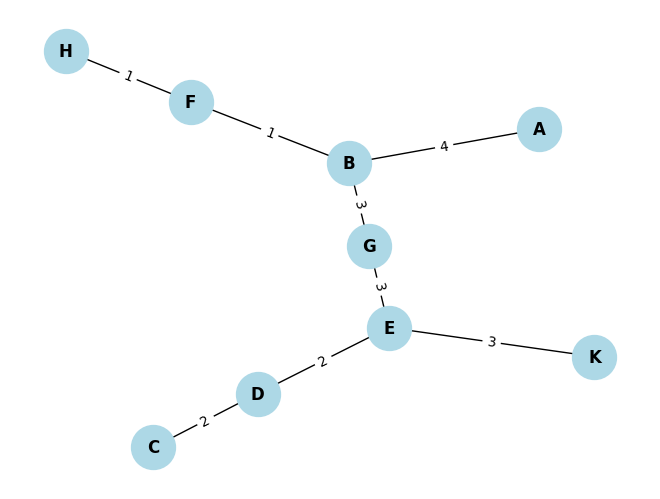

In [8]:
prim(DIJKSTRA, 'C').draw()

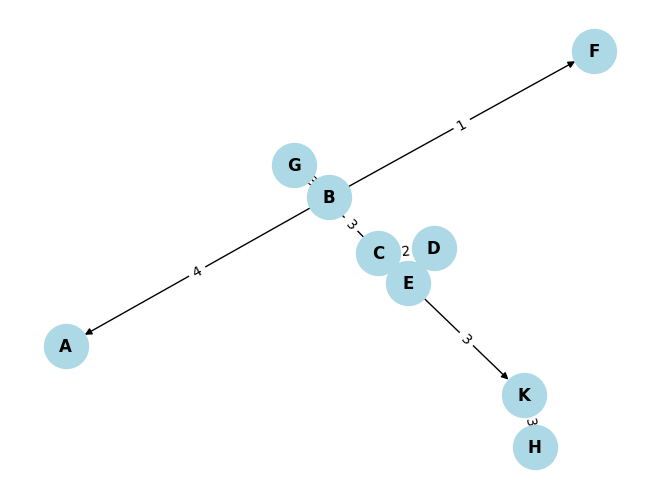

In [9]:
# the automated layout of graphs is semi-random
# you may need to re-run this cell several times to get a good layout
dijkstra(DIJKSTRA, 'C').draw()

### 18.4.3 Applications

The following exercises show applications of the SSSP problem and Dijkstra's
algorithm.

#### Exercise 18.4.2

Sometimes we want to solve the **single-pair shortest path** problem:
find the shortest path between a given start and a given end node.
How would you change Dijkstra's algorithm so that instead of a tree it returns
a sequence of nodes representing the shortest path from
the start to the end node? The end node is an extra input of the new algorithm.
If the end node is not reachable from the start node,
the output sequence is empty.

You don't have to rewrite the algorithm or the code:
a brief description of the changes suffices.

_Write your answer here._

[Hint](../31_Hints/Hints_18_4_02.ipynb)
[Answer](../32_Answers/Answers_18_4_02.ipynb)

#### Exercise 18.4.3

Sometimes a problem setter has a vague idea of what they want and
the problem solver has to provide a precise and implementable definition.
This exercise presents such a scenario.
It's a modelling exercise without one right answer.

You were [previously asked](../17_Graphs_1/17_2_concepts.ipynb#Exercise-17.2.1)
by an advertising agency to determine the best train stations for displaying
an advert, given an undirected unweighted graph of the rail network.
Suppose the edges are now weighted with the travel times.

The agency thinks the adverts will be seen by more people in central stations.
You're asked to come up with a precise definition of which node or nodes
in a weighted undirected connected graph are central and to outline an algorithm
to find them. The algorithm doesn't have to be efficient.

_Write your answer here._

[Hint](../31_Hints/Hints_18_4_03.ipynb)
[Answer](../32_Answers/Answers_18_4_03.ipynb)

⟵ [Previous section](18_3_mst.ipynb) | [Up](18-introduction.ipynb) | [Next section](18_5_summary.ipynb) ⟶